In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'STERV.HE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,2514,-2064,450,123,1523,1621,1444,4663,0,...,0,0,584,2982,3872,7994,188,-229,788.6,2014-10-21
1,2014-12-31,2552,-2093,459,-134,1446,1484,1403,4415,242,...,0,2,611,3127,3530,7777,362,-264,788.6,2015-02-01
2,2015-03-31,2491,-2017,474,129,1321,1550,1507,4522,248,...,0,1,606,3193,3618,7917,52,-142,788.6,2015-04-21
3,2015-06-30,2562,-2137,425,123,987,1531,1421,4008,247,...,0,1,557,3019,3337,7465,419,-228,788.6,2015-07-21
4,2015-09-30,2500,-2041,459,124,798,1418,1389,3671,247,...,0,1,206,2679,3334,7077,393,-250,788.6,2015-10-21


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-10-21,788.6,2127,-1947,180,-34,2077,1258,1652,...,468,20226,0,580,489,3355,4182,9158,205,-193
37,2023-12-31,2024-02-01,788.6,2174,-2030,144,-325,2464,1191,1466,...,391,20754,0,418,286,3004,4446,9768,272,-328
38,2024-03-31,2024-04-22,789.7,2164,-1844,320,84,2099,1139,1478,...,290,20305,0,623,248,2999,4310,9632,269,-373
39,2024-06-30,2024-07-22,789.6,2301,-1950,351,42,2074,1060,1486,...,280,20327,0,557,522,3311,4069,9693,188,-237
40,2024-09-30,2024-10-21,789.6,2261,-1959,302,84,1999,1048,1696,...,296,20387,0,732,839,3855,3855,9668,221,-267


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-21,788.6,2127,-1947,180,-34,2077,1258,1652,...,20226,0,580,489,3355,4182,9158,205,-193,0.918837
37,2023-12-31,2024-02-01,788.6,2174,-2030,144,-325,2464,1191,1466,...,20754,0,418,286,3004,4446,9768,272,-328,0.929674
38,2024-03-31,2024-04-22,789.7,2164,-1844,320,84,2099,1139,1478,...,20305,0,623,248,2999,4310,9632,269,-373,0.920544
39,2024-06-30,2024-07-22,789.6,2301,-1950,351,42,2074,1060,1486,...,20327,0,557,522,3311,4069,9693,188,-237,0.928647
40,2024-09-30,2024-10-21,789.6,2261,-1959,302,84,1999,1048,1696,...,20387,0,732,839,3855,3855,9668,221,-267,0.910617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-21,788.6,2127,-1947,180,-34,2077,1258,1652,...,20226,0,580,489,3355,4182,9158,205,-193,0.918837
37,2023-12-31,2024-02-01,788.6,2174,-2030,144,-325,2464,1191,1466,...,20754,0,418,286,3004,4446,9768,272,-328,0.929674
38,2024-03-31,2024-04-22,789.7,2164,-1844,320,84,2099,1139,1478,...,20305,0,623,248,2999,4310,9632,269,-373,0.920544
39,2024-06-30,2024-07-22,789.6,2301,-1950,351,42,2074,1060,1486,...,20327,0,557,522,3311,4069,9693,188,-237,0.928647
40,2024-09-30,2024-10-21,789.6,2261,-1959,302,84,1999,1048,1696,...,20387,0,732,839,3855,3855,9668,221,-267,0.910617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-10-27,4.830070,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.395995,0.604005,0.0,0.0,0.0,0.0,0.178998,0.048926,0.0,0.0
1,2014-11-03,4.859454,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.395995,0.604005,0.0,0.0,0.0,0.0,0.178998,0.048926,0.0,0.0
2,2014-11-10,4.804358,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.395995,0.604005,0.0,0.0,0.0,0.0,0.178998,0.048926,0.0,0.0
3,2014-11-17,5.153299,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.395995,0.604005,0.0,0.0,0.0,0.0,0.178998,0.048926,0.0,0.0
4,2014-11-24,5.234106,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.395995,0.604005,0.0,0.0,0.0,0.0,0.178998,0.048926,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-10-27,4.830070,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.0,0.178998,0.048926,0.0,0.0,inf,0.726768,inf,inf,inf
1,2014-11-03,4.859454,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.0,0.178998,0.048926,0.0,0.0,inf,0.731190,inf,inf,inf
2,2014-11-10,4.804358,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.0,0.178998,0.048926,0.0,0.0,inf,0.722900,inf,inf,inf
3,2014-11-17,5.153299,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.0,0.178998,0.048926,0.0,0.0,inf,0.775404,inf,inf,inf
4,2014-11-24,5.234106,2014-09-30,2514.0,0.0,6.645955,788.6,0.0,0.0,1523.0,...,0.0,0.178998,0.048926,0.0,0.0,inf,0.787563,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

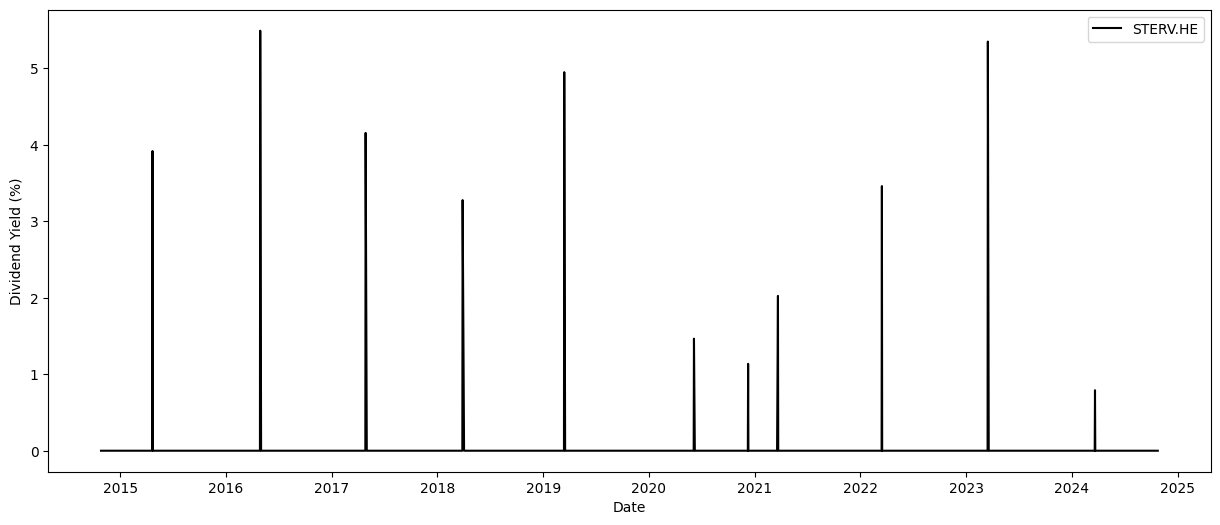

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.017419
share_price      1.000000
Name: share_price, dtype: float64


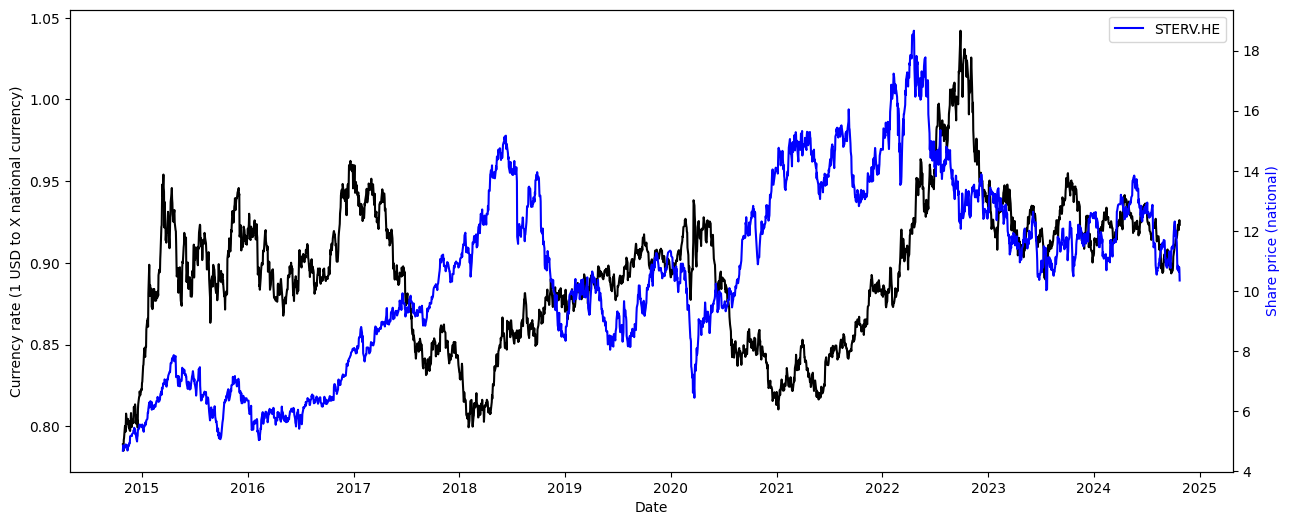

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

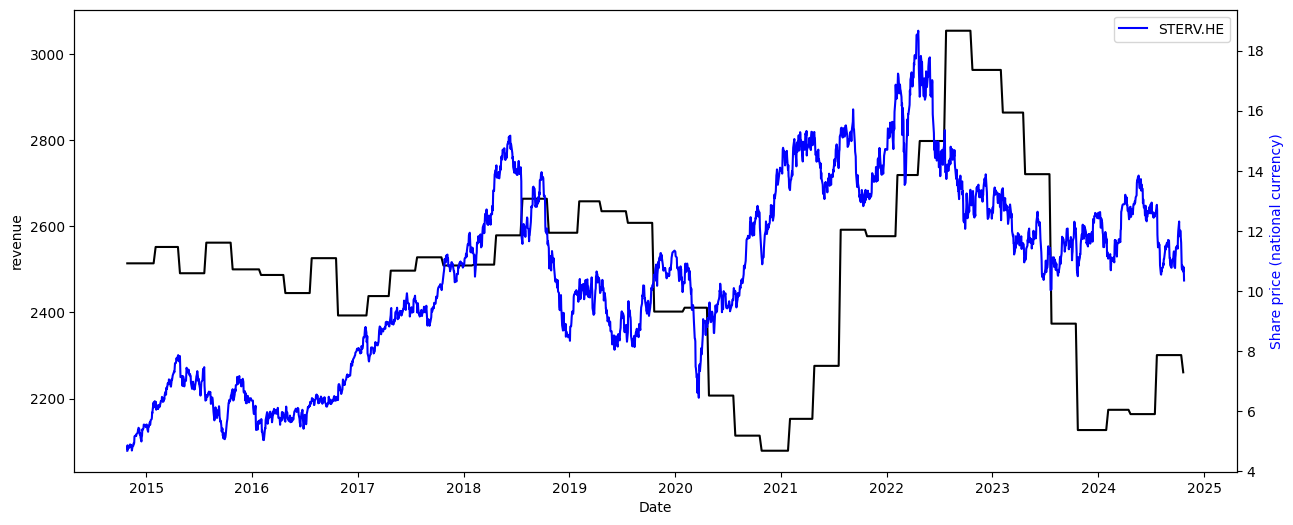

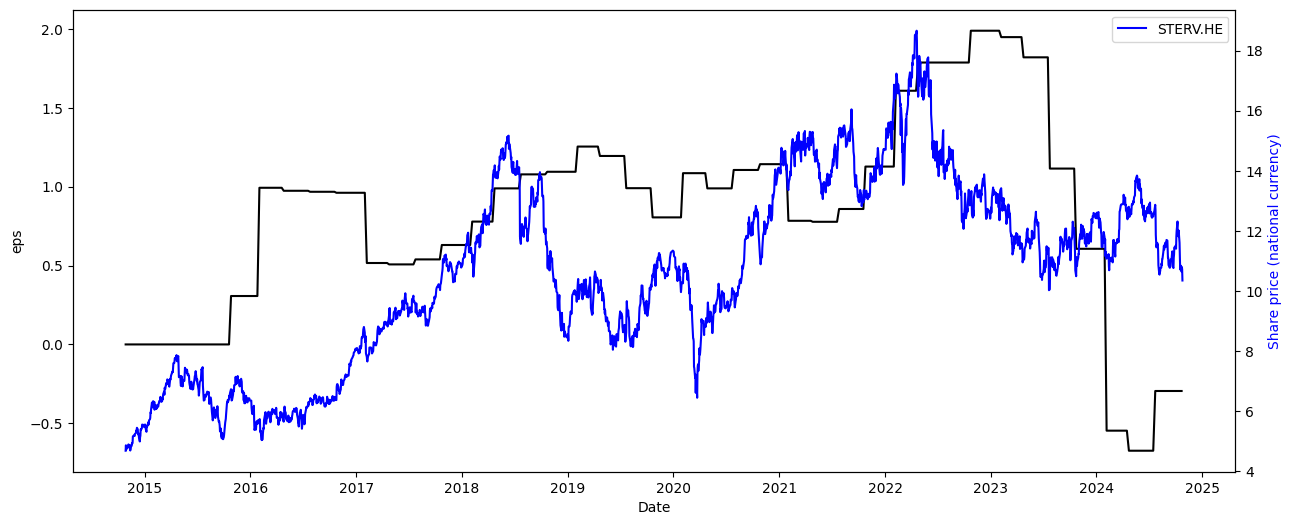

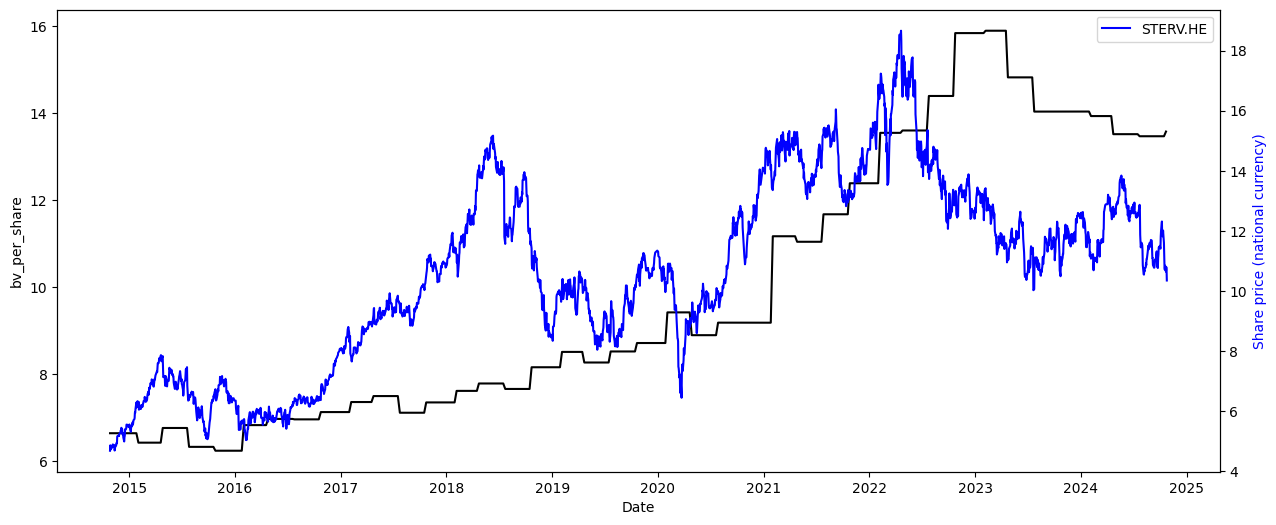

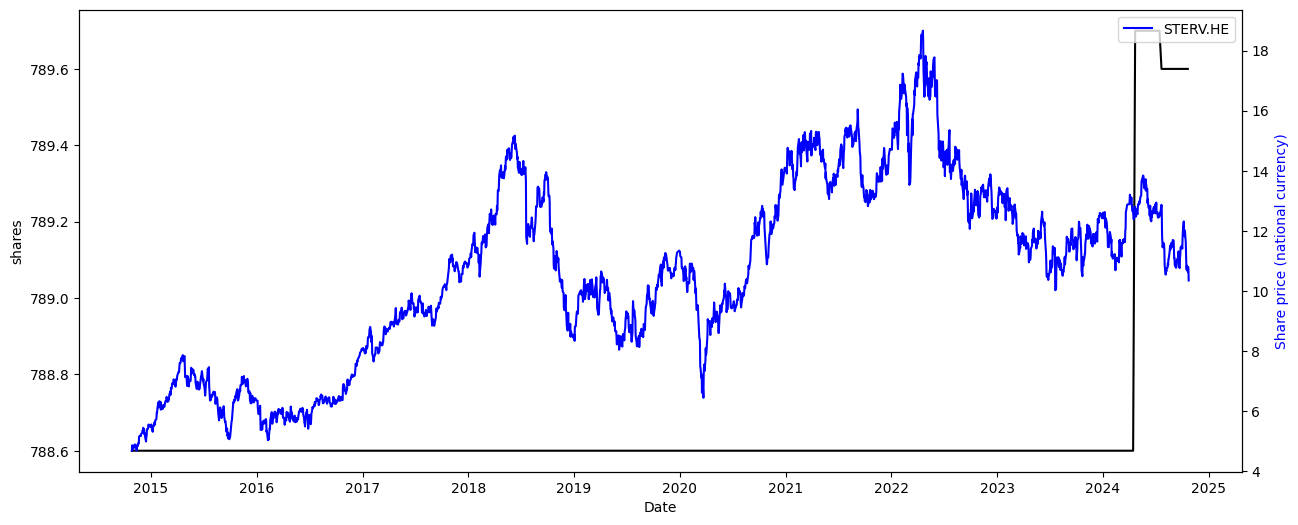

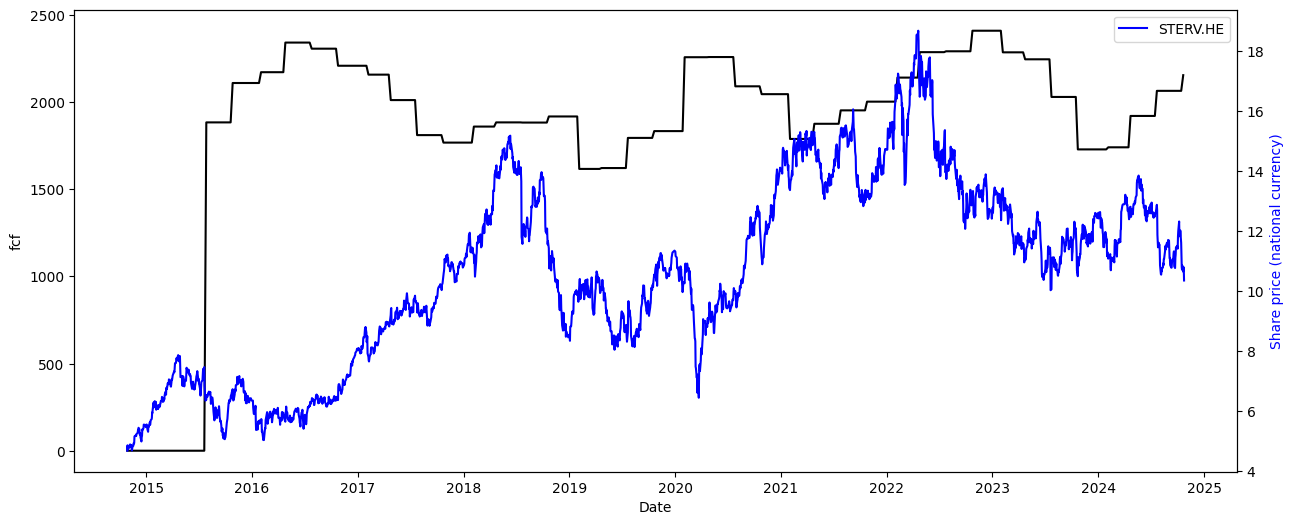

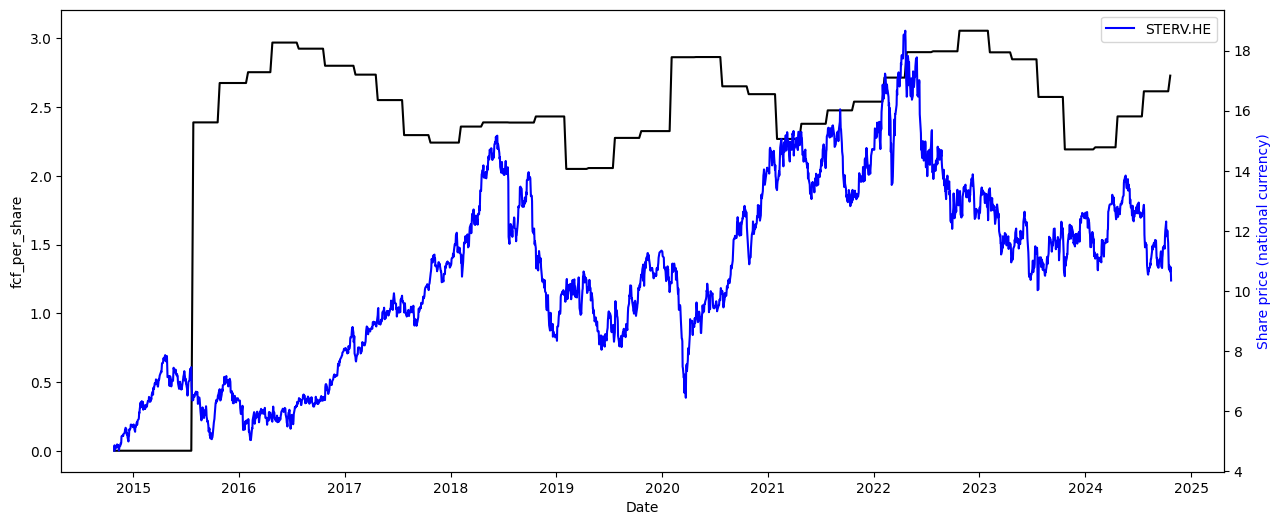

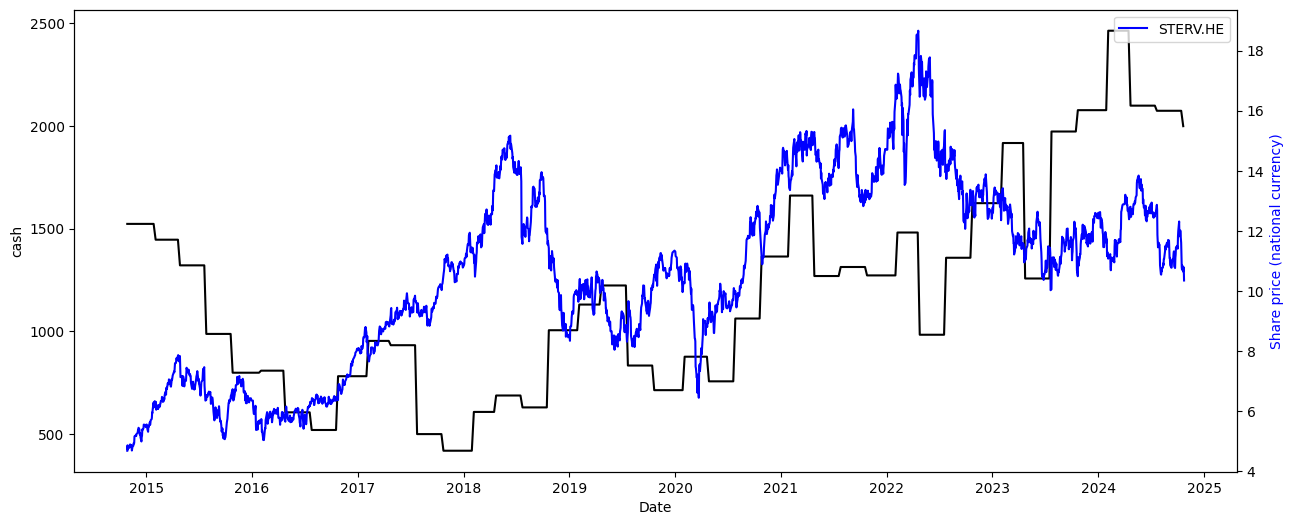

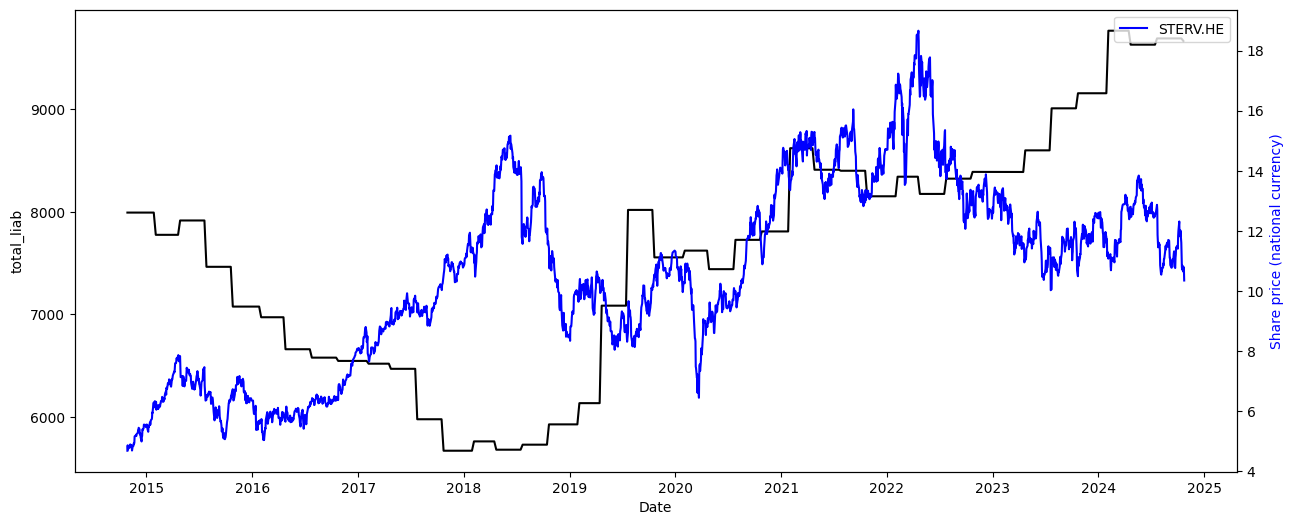

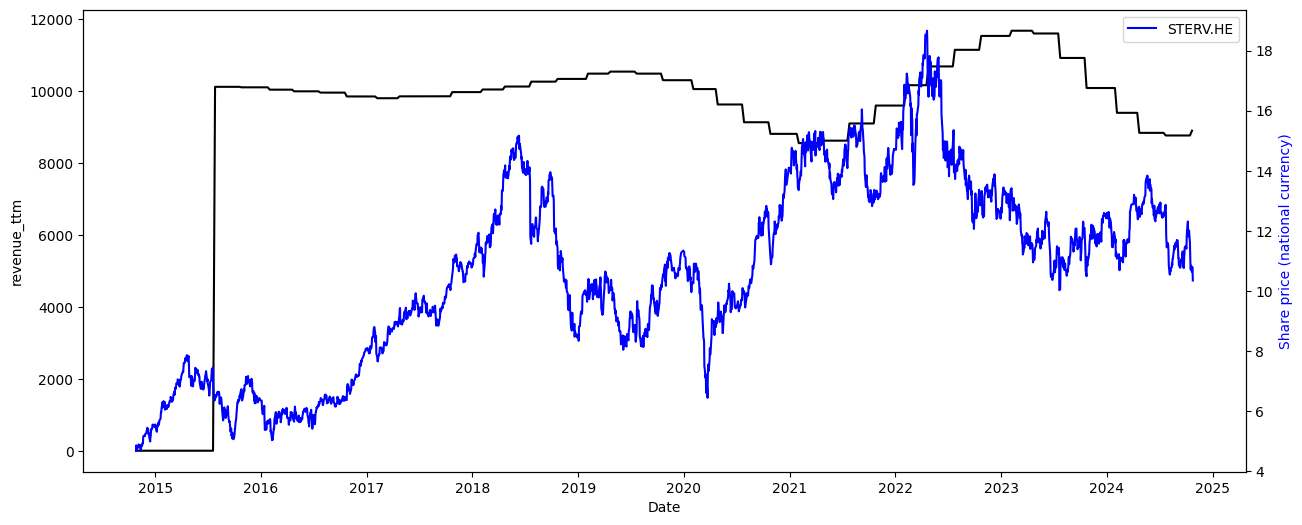

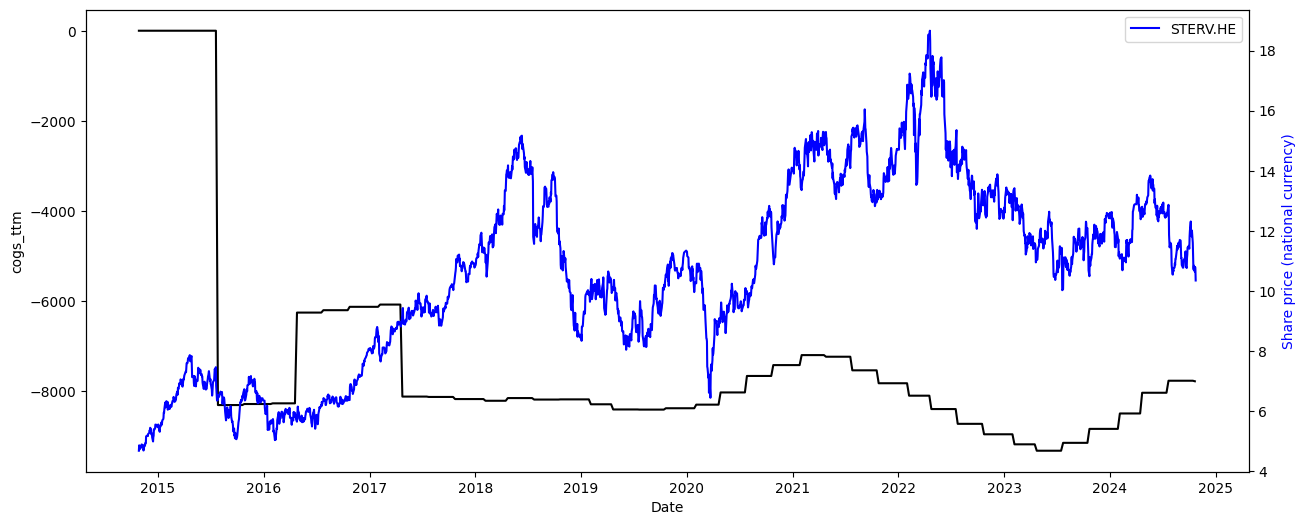

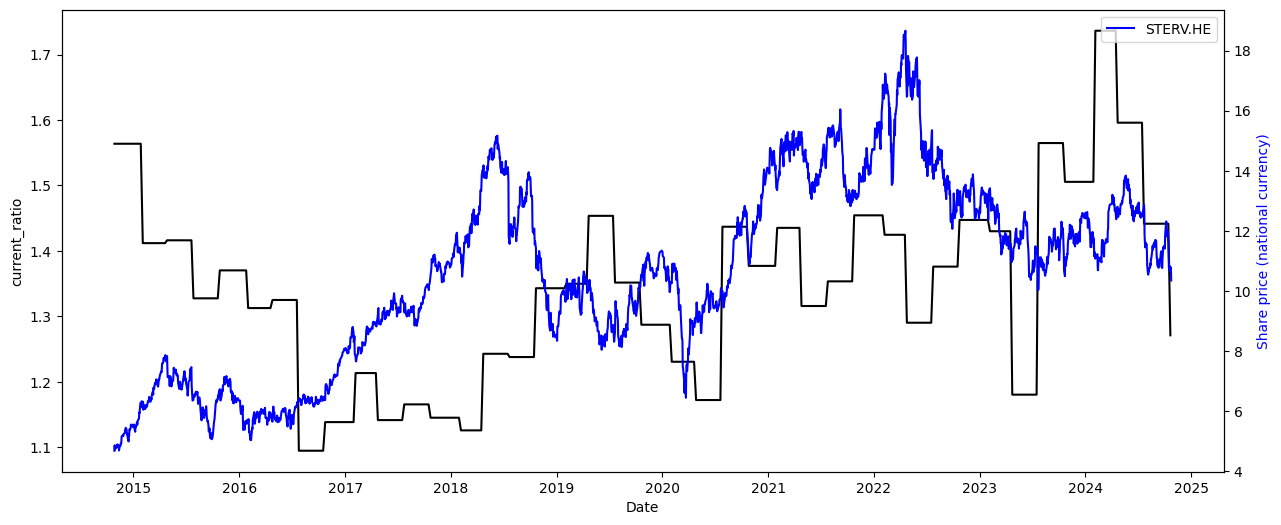

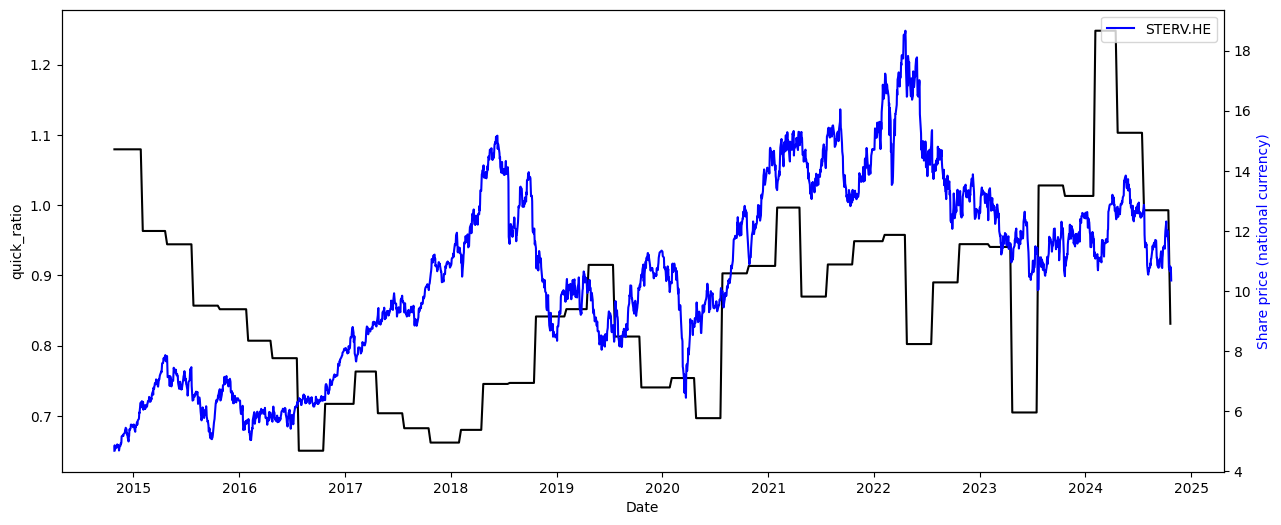

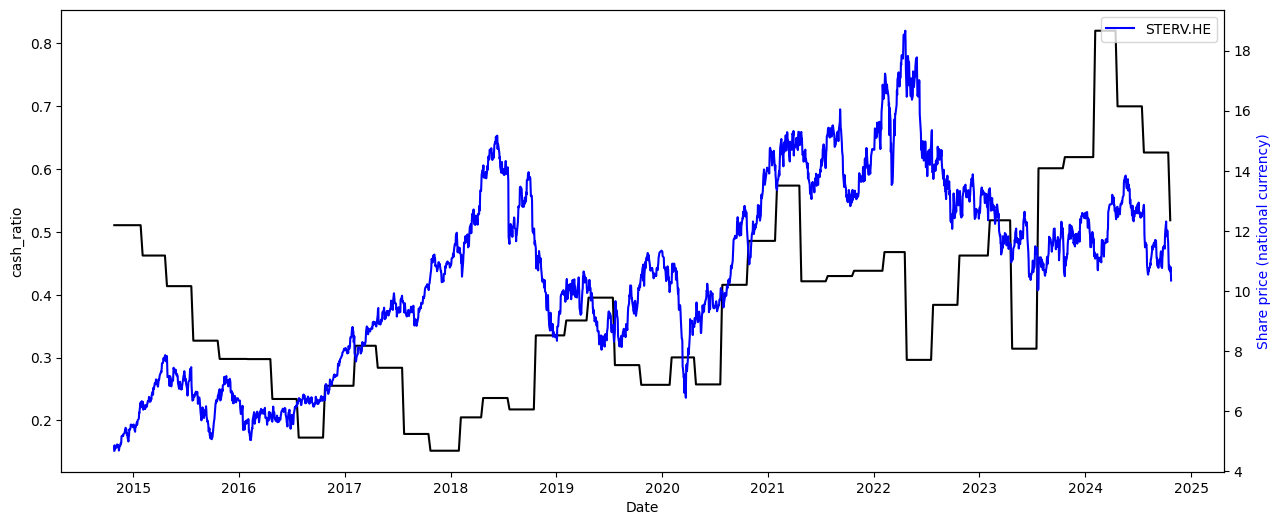

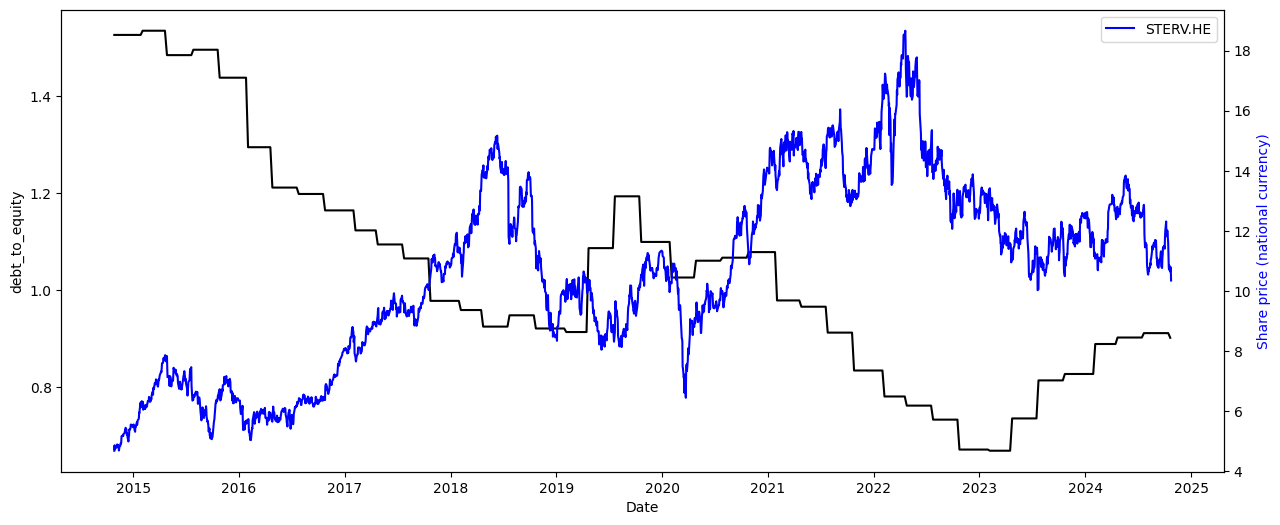

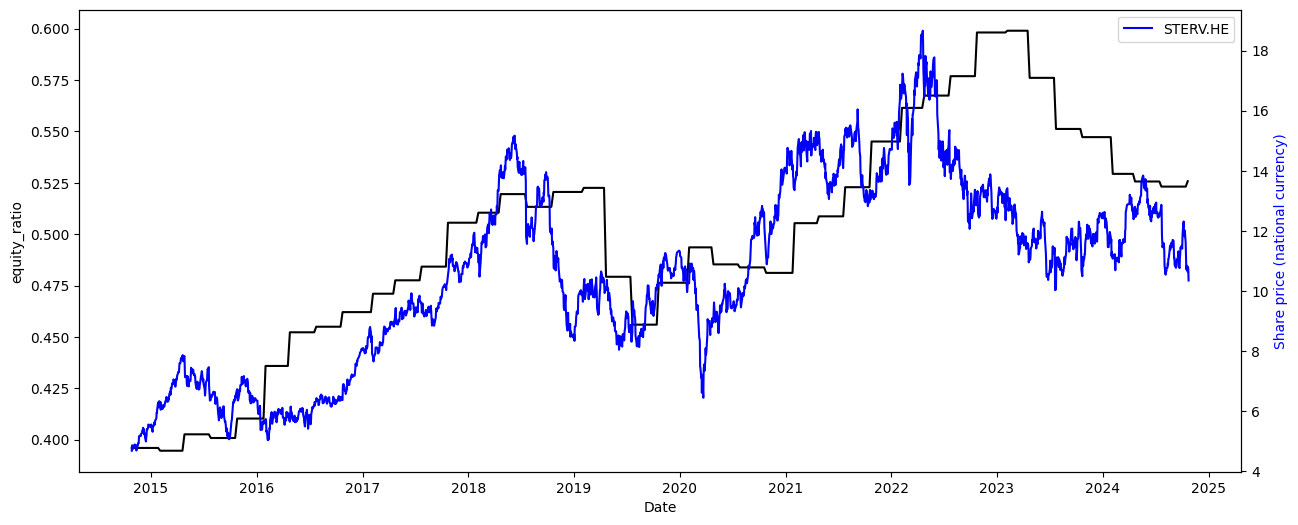

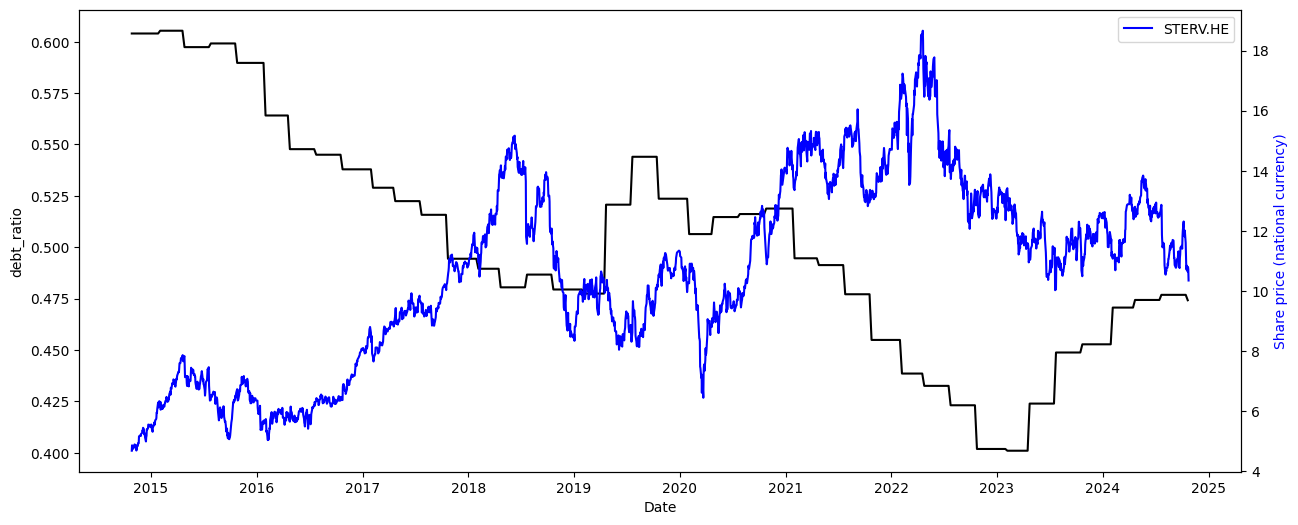

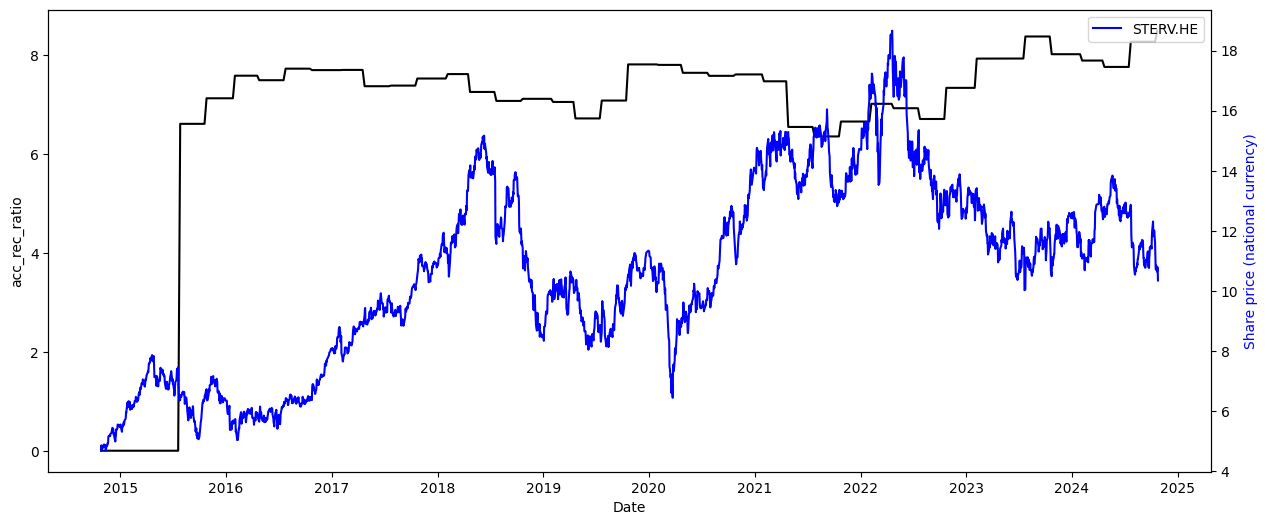

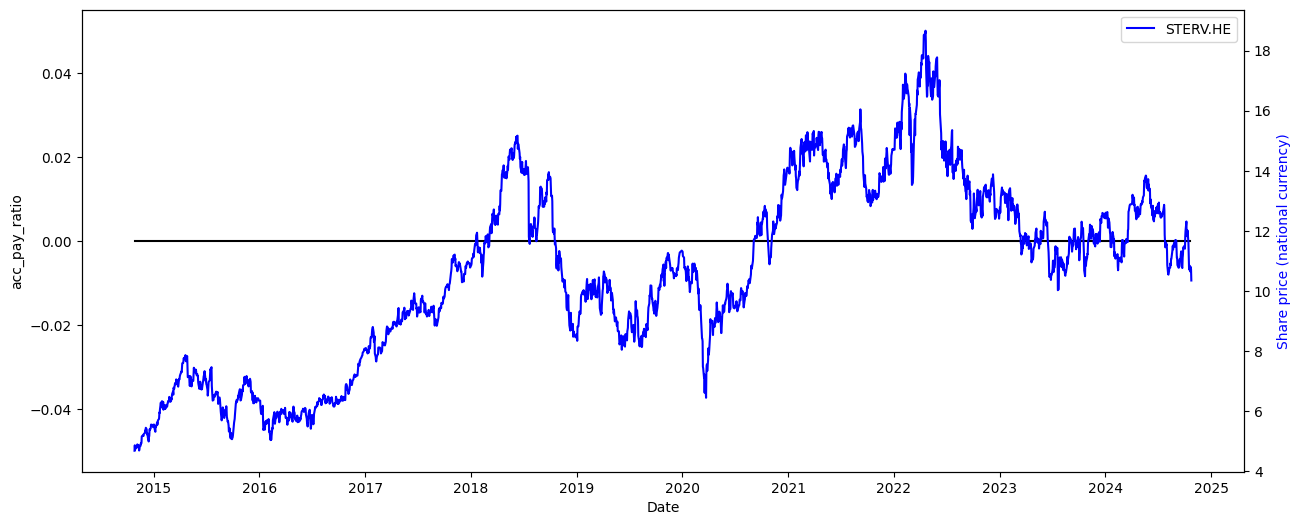

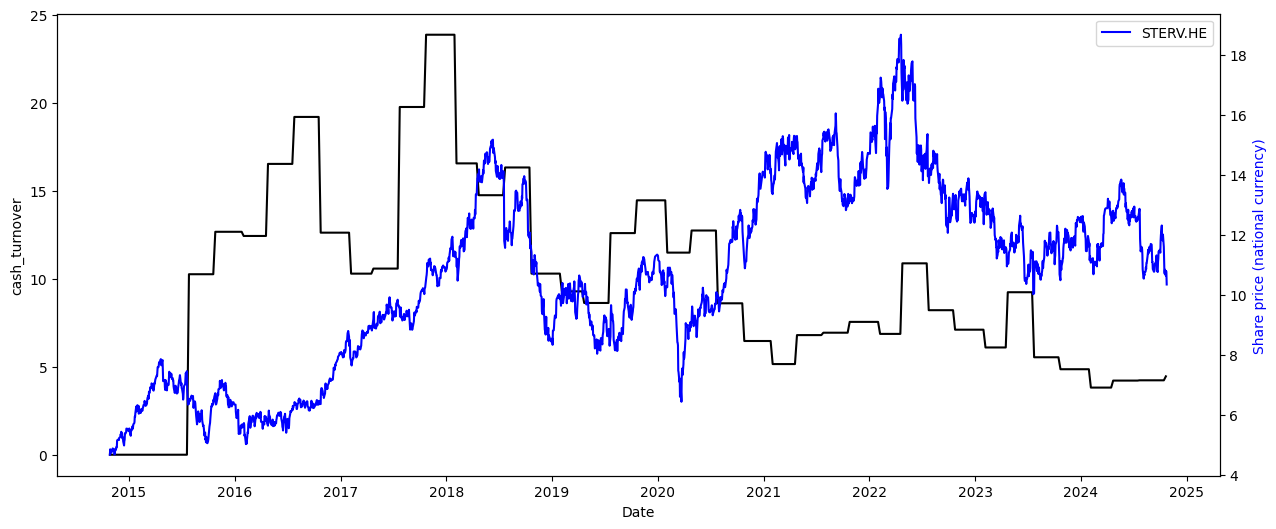

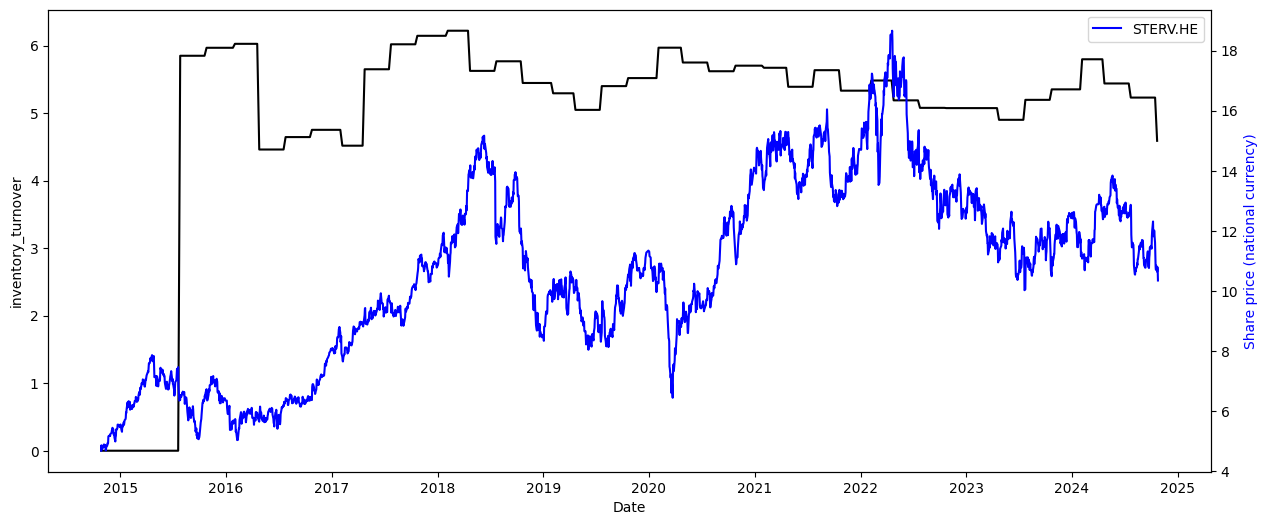

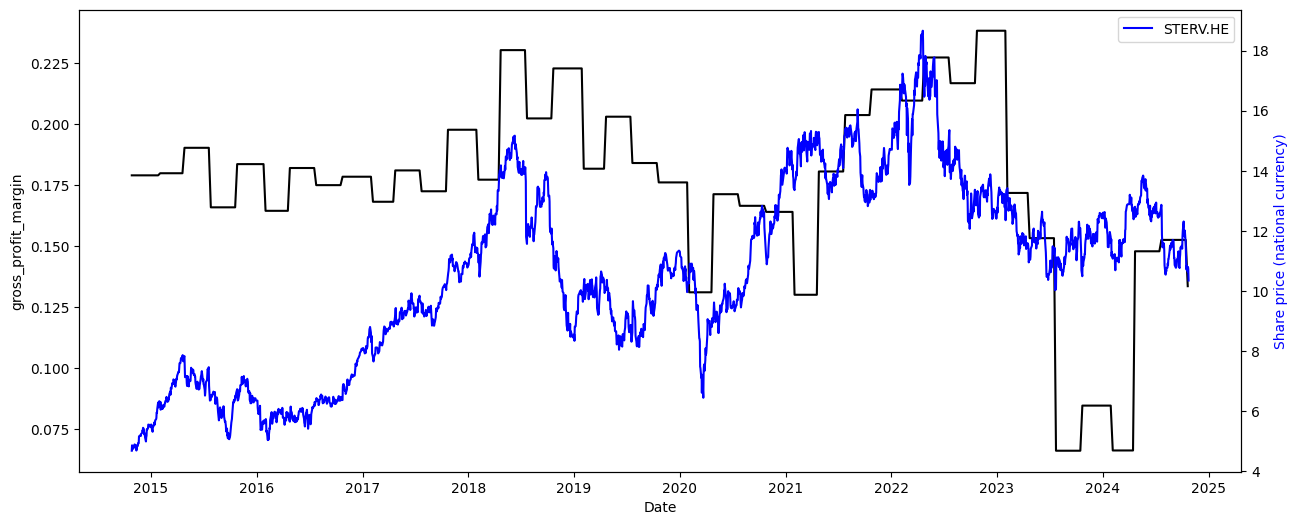

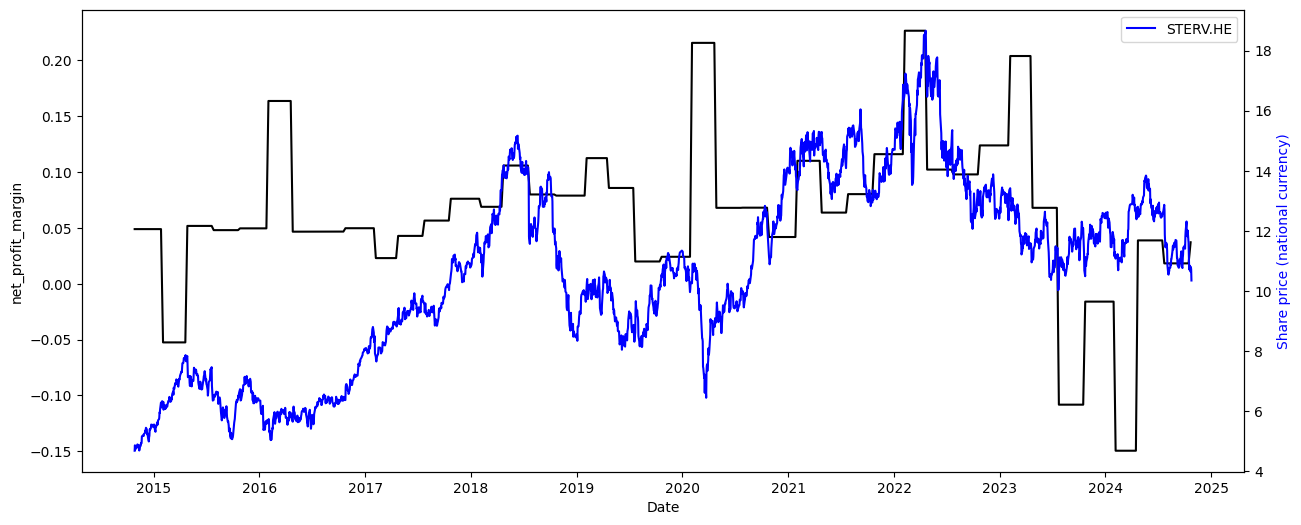

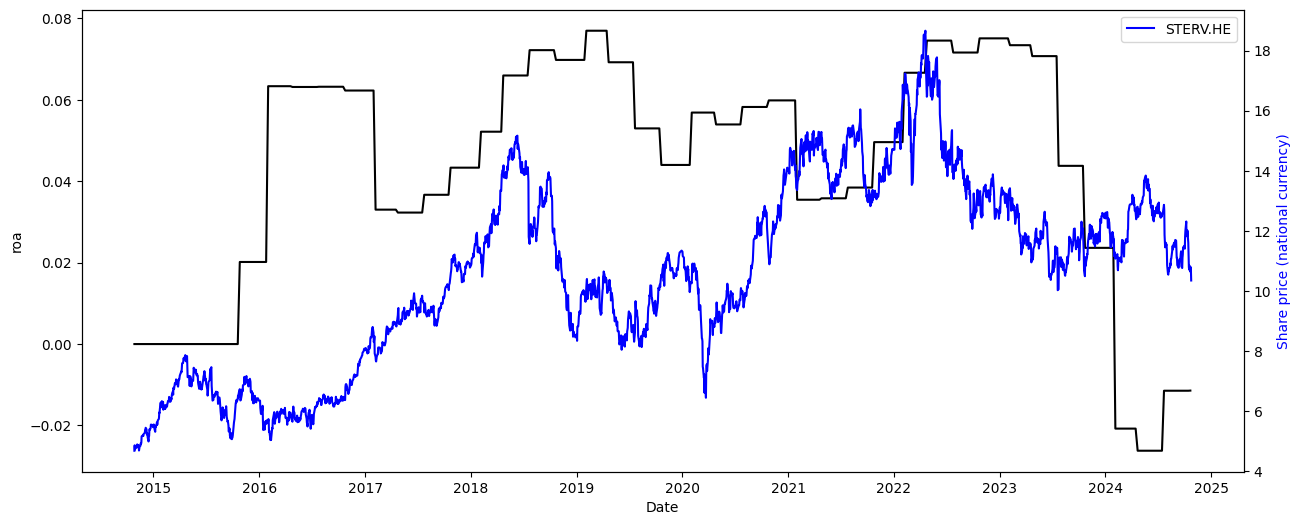

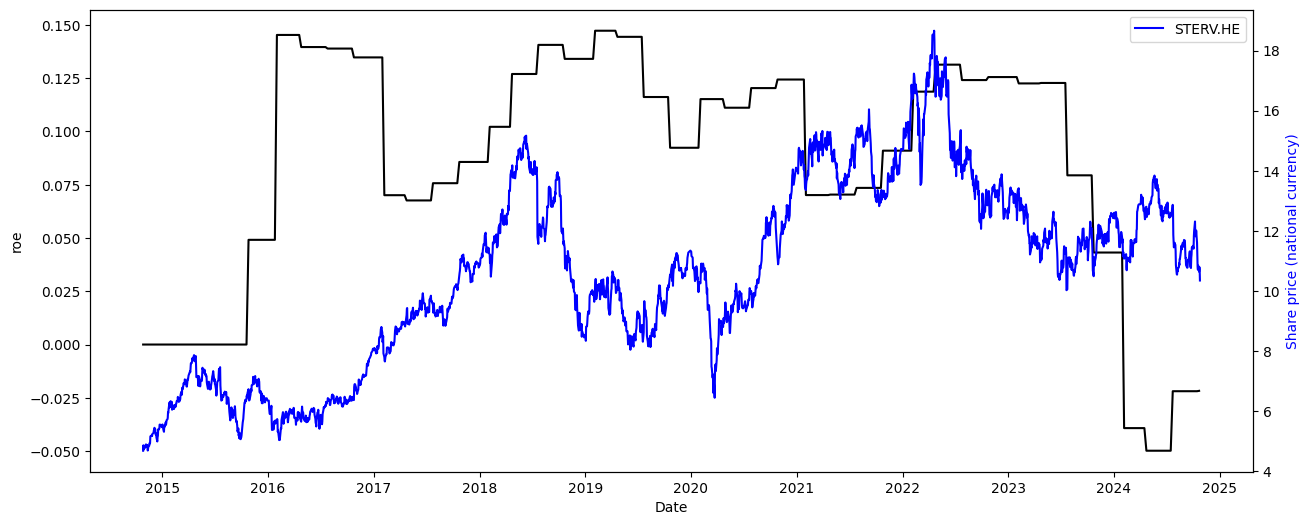

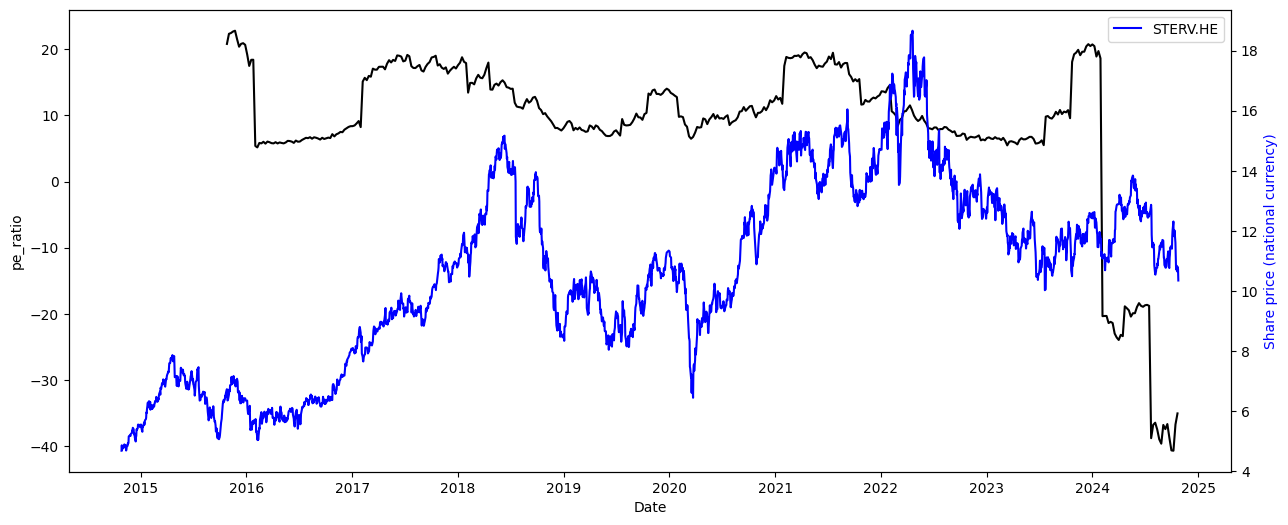

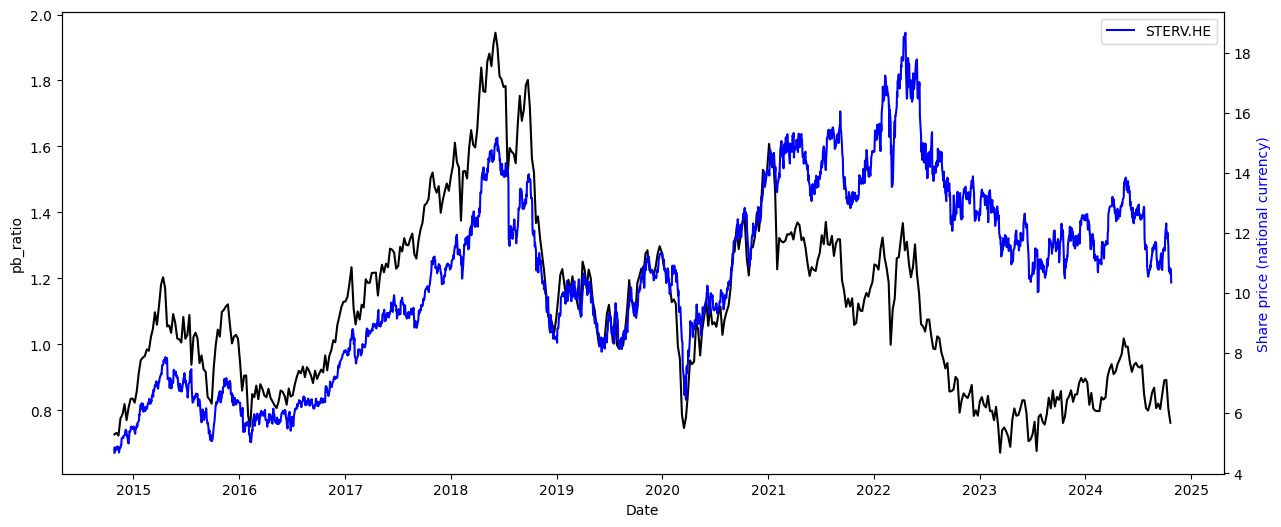

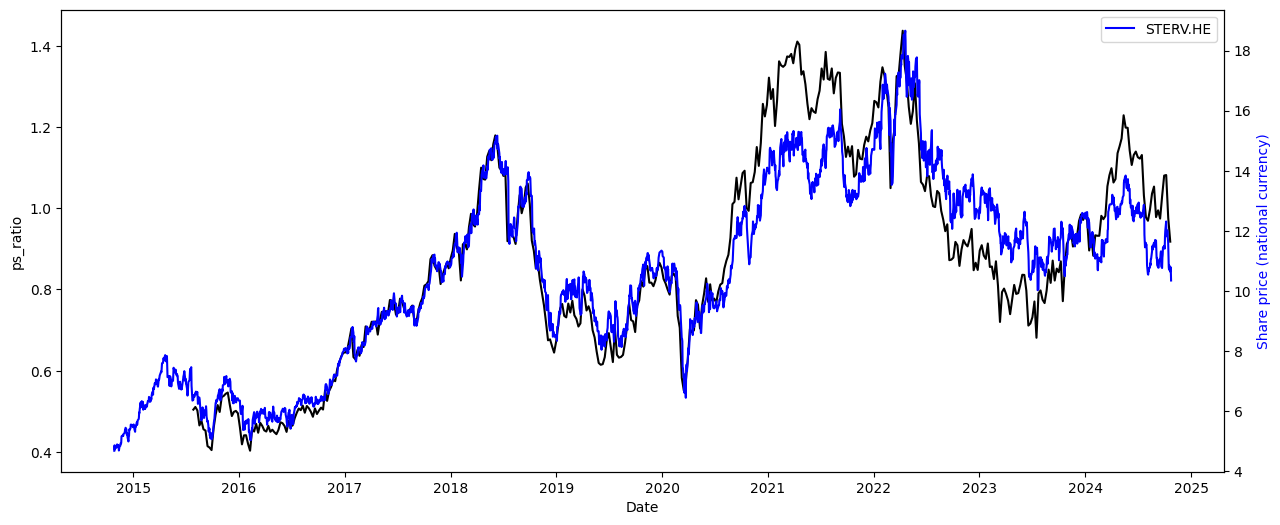

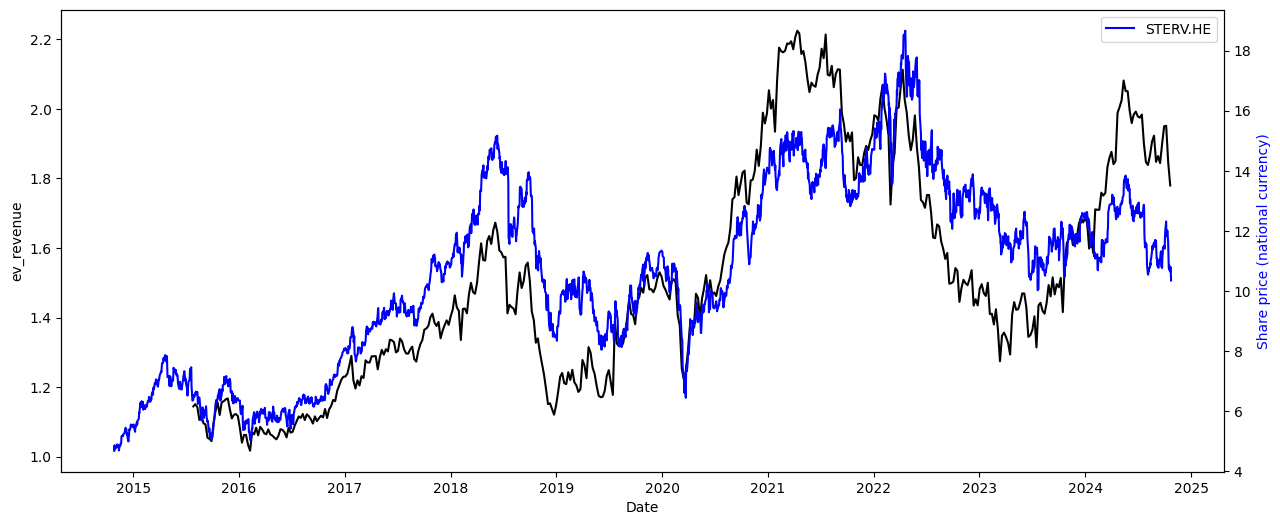

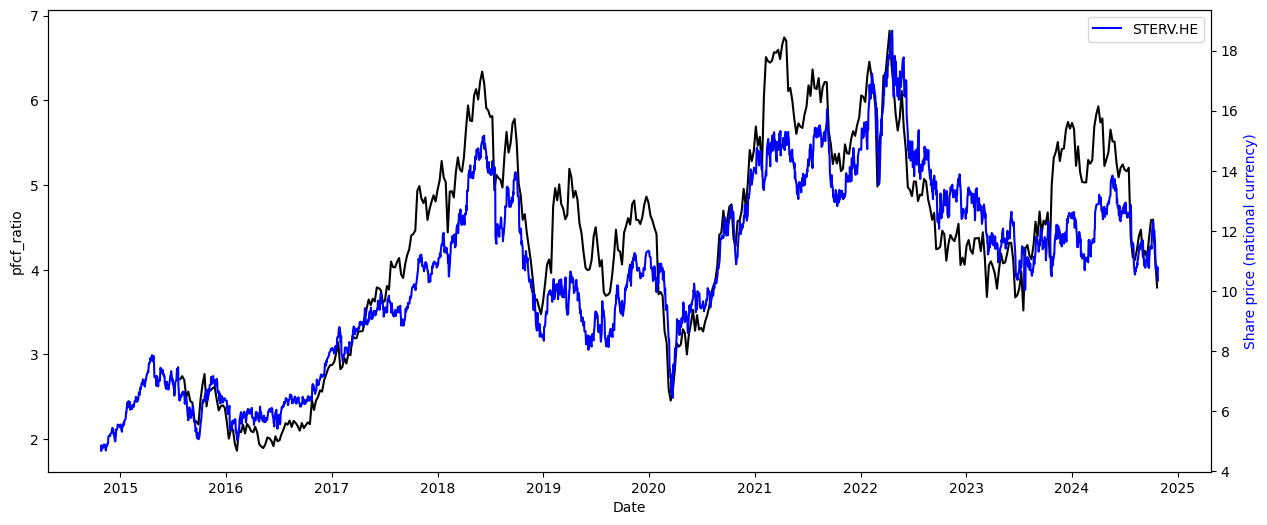

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

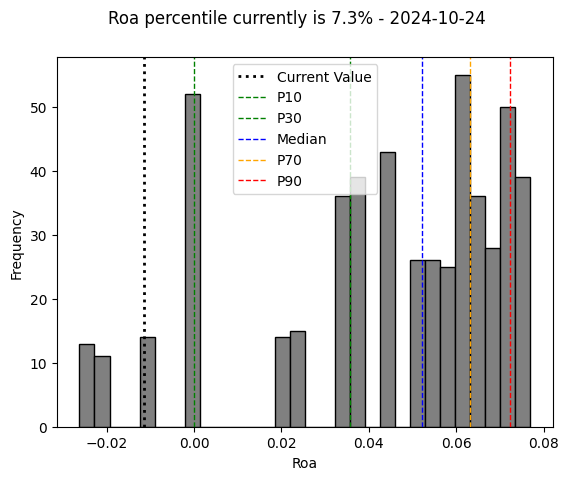

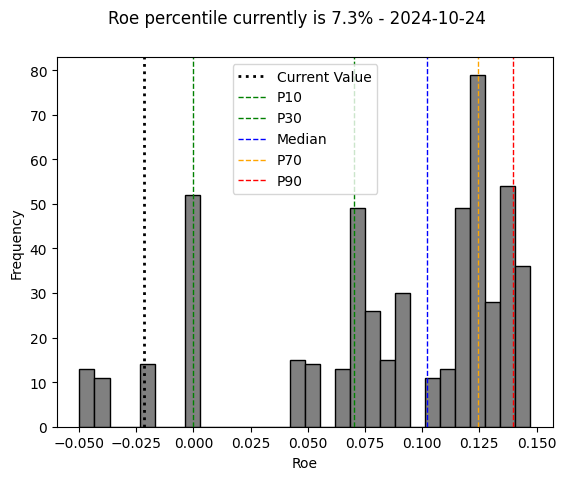

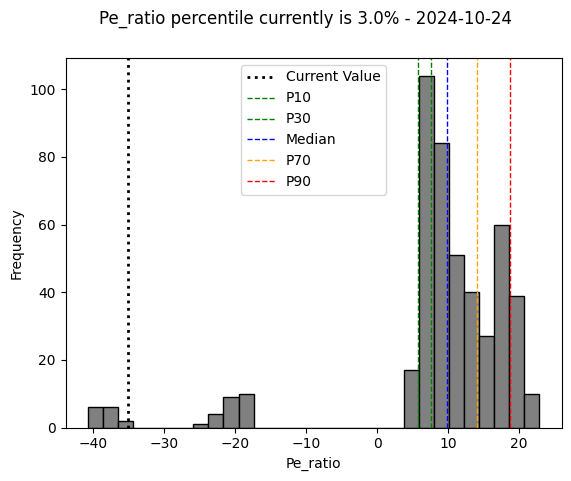

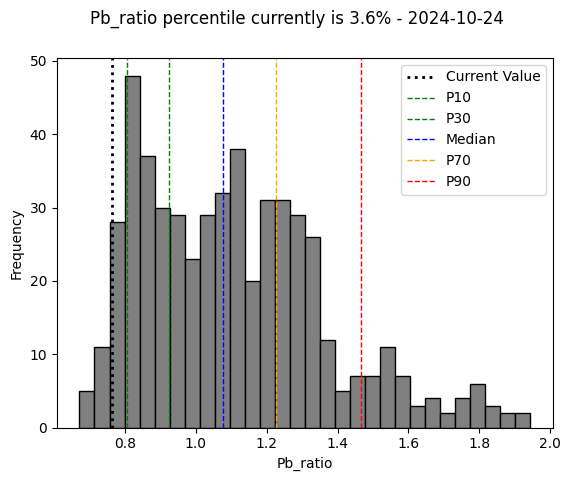

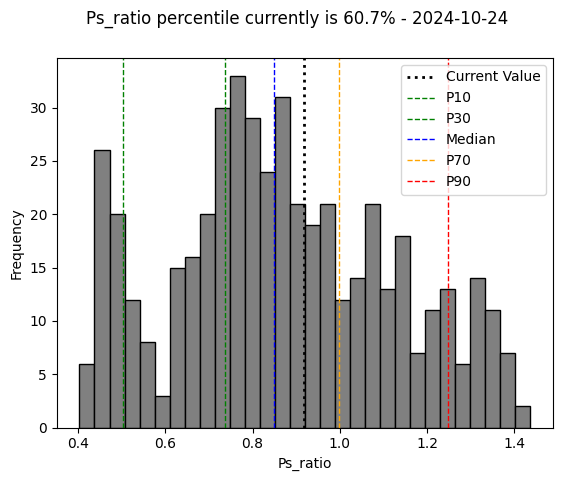

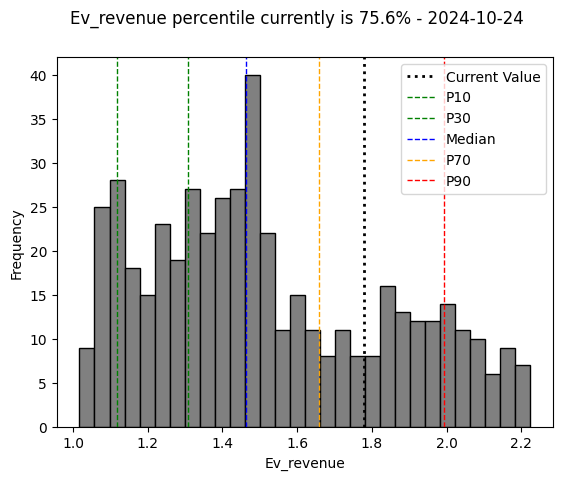

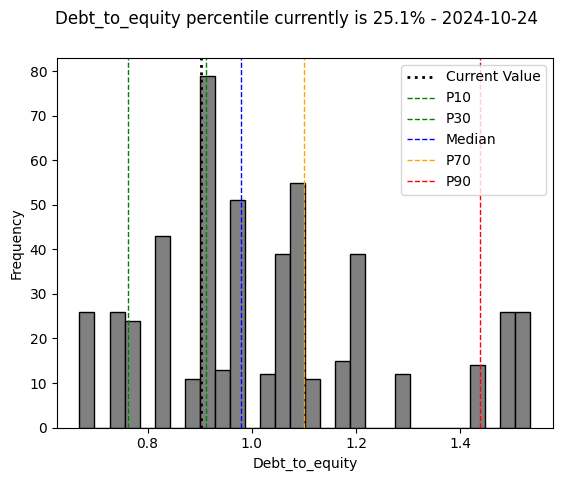

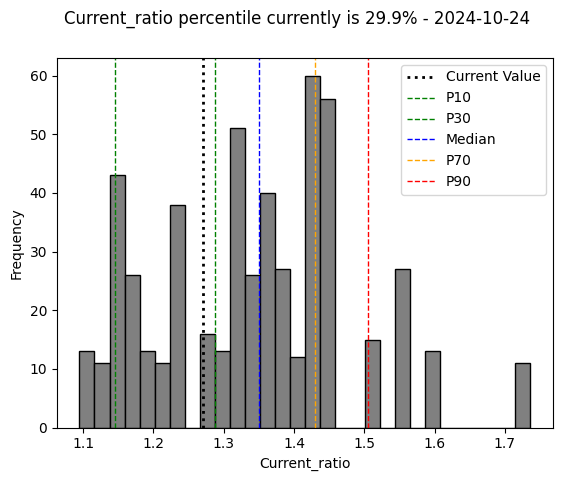

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.985358,0.497573,0.226172,-0.109485,-0.280145,-0.430224,-0.452406
roe,0.985358,1.000000,0.513214,0.247076,-0.198626,-0.352198,-0.322768,-0.501884
pe_ratio,0.497573,0.513214,1.000000,0.430916,-0.041843,-0.176320,0.185038,-0.425889
pb_ratio,0.226172,0.247076,0.430916,1.000000,0.436002,0.256762,-0.049427,-0.405366
ps_ratio,-0.109485,-0.198626,-0.041843,0.436002,1.000000,0.959093,-0.600576,0.342075
ev_revenue,-0.280145,-0.352198,-0.176320,0.256762,0.959093,1.000000,-0.501942,0.435847
debt_to_equity,-0.430224,-0.322768,0.185038,-0.049427,-0.600576,-0.501942,1.000000,-0.091226
current_ratio,-0.452406,-0.501884,-0.425889,-0.405366,0.342075,0.435847,-0.091226,1.000000


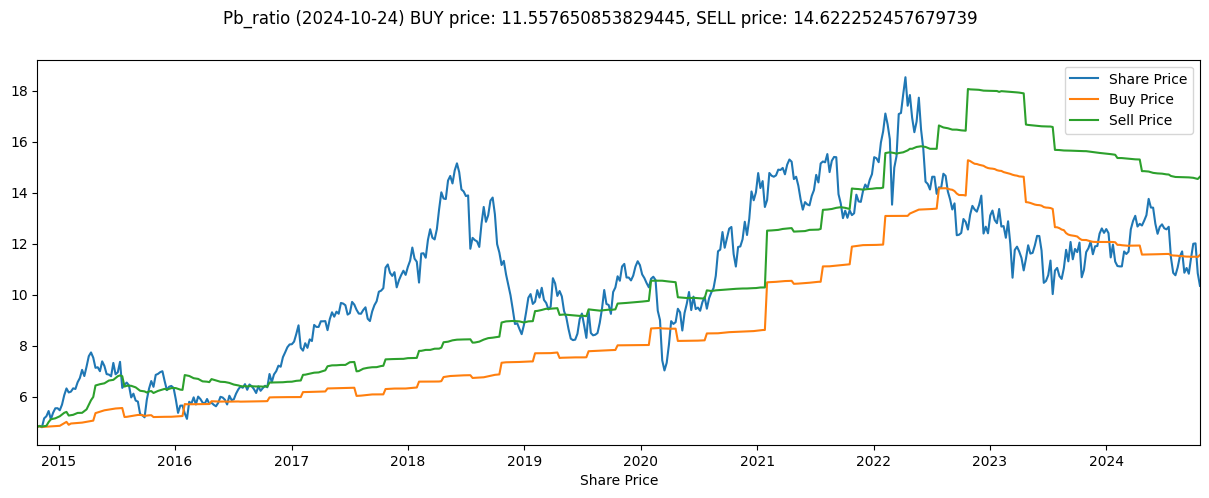

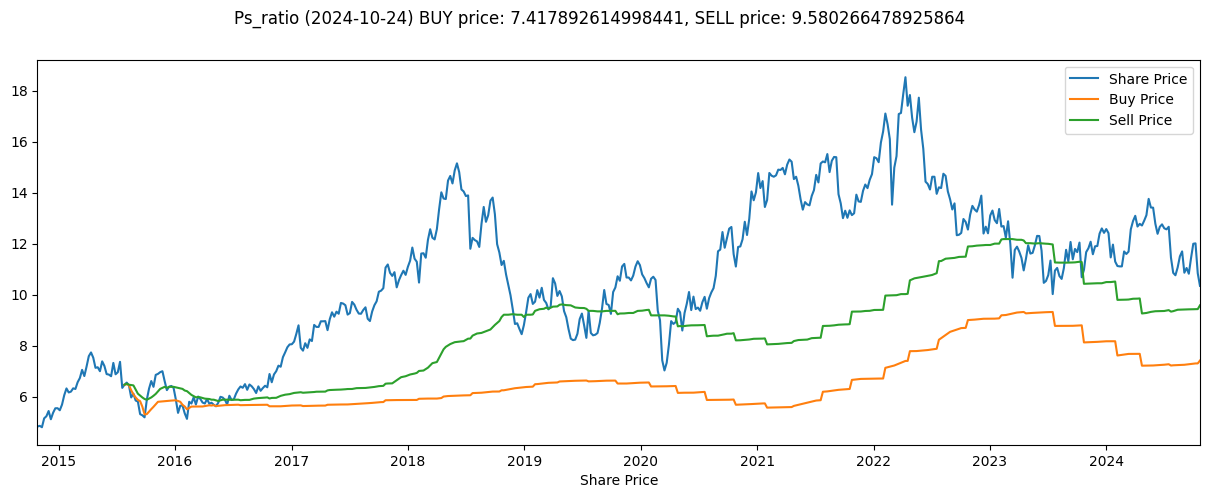

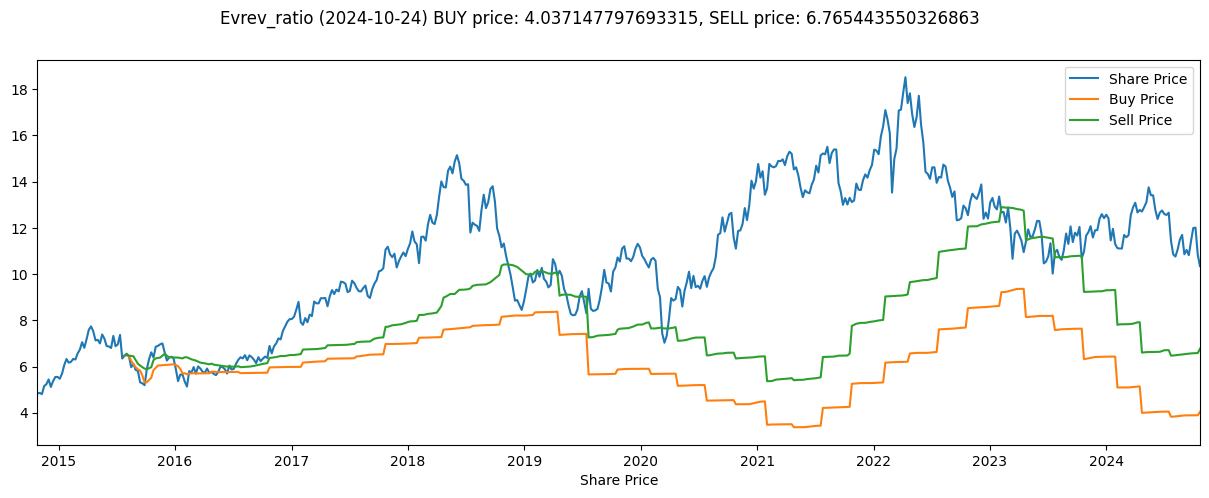

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)